In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch as T
from tqdm import tqdm


import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [18]:
boardSize = (15,15)   # Legt die Größe des Feldes fest
timeSteps = 20 # Legt die Spieldauer fest (Anz. Iterationen)
safeDist = 3
netScaler = 1
Layer1 = int(128*netScaler)
Layer2 = int(256*netScaler)
Layer3 = int(128*netScaler)

In [3]:
def showhist(hist):
        for i in range(len(hist)):
            #print(hist[int(i)])
            if all(elm < boardSize[0] for elm in hist[int(i)]):
                h = hist[i].astype(np.int)
                m = np.ones(boardSize)


                m[h[4], h[5]] = 0.9 
                m[h[6], h[7]] = 0.9
                m[h[8], h[9]] = 0.9
                m[h[10], h[11]] = 0.9
                m[h[12], h[13]] = 0.9
                m[h[14], h[15]] = 0.9
                m[h[16], h[17]] = 0.9

                #for j in range(0,7):
                #    m[h[4+j],h[4+j+1]] = 0.9
                m[h[0],h[1]] = 0
                m[h[2],h[3]] = 0.5
                print("Player: (" + str(h[0]) +"," + str(h[1]) + "), Aim: (" + str(h[2]) + "," + str(h[3]) +") ")
                plt.imshow(m, cmap='hot', interpolation='nearest')
                plt.show()

def showhist_map(hist):
        for i in range(len(hist)):
            #print(hist[int(i)])
            if all(elm < boardSize[0] for elm in hist[int(i)]):
                h = hist[i].astype(np.int)
                
                #print("Player: (" + str(h[0]) +"," + str(h[1]) + "), Aim: (" + str(h[2]) + "," + str(h[3]) +") ")
                print("MIN:" + str(np.max(hist[i])) + " " + str(np.min(hist[i])))
                plt.imshow(hist[i].reshape(boardSize[0], boardSize[1]), cmap='hot', interpolation='nearest')
                plt.show()
                
                
            
def showReward(h):
    obstacles = [obstacle(7,5),
                 obstacle(5,5),
                 obstacle(3,5),
                 obstacle(7,4),
                 obstacle(6,6),
                 obstacle(6,5),
                 obstacle(6,4)
    ]
    print(str(h[2])+ " " +str(h[3]))
    m = np.zeros(boardSize)
    for i in range(boardSize[0]):
        for j in range(boardSize[1]):
            m[i,j] , _= env.getRewardForField(i,j)
            if(m[i,j] > 30):
                m[i,j] = 10
    
    return m.astype(np.int)





In [4]:
class ReplayBuffer():
    def __init__(self, max_size, input_shape):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape),
                                    dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_shape),
                                        dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.uint8)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

In [5]:
class DuelingLinearDeepQNetwork(nn.Module):
    def __init__(self, ALPHA, n_actions, name, input_dims, chkpt_dir=''):
        super(DuelingLinearDeepQNetwork, self).__init__()

        self.fc1 = nn.Linear(*input_dims, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512,128)
        self.V = nn.Linear(128, 1)
        self.A = nn.Linear(128, n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=ALPHA)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_dqn')

    def forward(self, state):
        l1 = F.relu(self.fc1(state))
        l2 = F.relu(self.fc2(l1))
        l3 = F.relu(self.fc3(l2))
        V = self.V(l3)
        A = self.A(l3)

        return V, A

    def save_checkpoint(self):
        #print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        #print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))

In [6]:
class Agent():
    def __init__(self, gamma, epsilon, lr, n_actions, input_dims,
                 mem_size, batch_size, eps_min=0.01, eps_dec=5e-7,
                 replace=1000, chkpt_dir=''):
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.n_actions = n_actions
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.eps_min = eps_min
        self.eps_dec = eps_dec
        self.replace_target_cnt = replace
        self.chkpt_dir = chkpt_dir
        self.action_space = [i for i in range(self.n_actions)]
        self.learn_step_counter = 0
        print(mem_size)
        print(input_dims)
        print(n_actions)
        self.memory = ReplayBuffer(mem_size, input_dims)

        self.q_eval = DuelingLinearDeepQNetwork(self.lr, self.n_actions,
                                   input_dims=self.input_dims,
                                   name='model',
                                   chkpt_dir=self.chkpt_dir)

        self.q_next = DuelingLinearDeepQNetwork(self.lr, self.n_actions,
                                   input_dims=self.input_dims,
                                   name='model_next',
                                   chkpt_dir=self.chkpt_dir)

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor([observation],dtype=T.float).to(self.q_eval.device)
            _, advantage = self.q_eval.forward(state)
            action = T.argmax(advantage).item()
        else:
            action = np.random.choice(self.action_space)

        return action

    def store_transition(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def replace_target_network(self):
        if self.learn_step_counter % self.replace_target_cnt == 0:
            self.q_next.load_state_dict(self.q_eval.state_dict())

    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec \
                        if self.epsilon > self.eps_min else self.eps_min

    def save_models(self):
        self.q_eval.save_checkpoint()
        self.q_next.save_checkpoint()

    def load_models(self):
        self.q_eval.load_checkpoint()
        self.q_next.load_checkpoint()

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        self.q_eval.optimizer.zero_grad()

        self.replace_target_network()

        state, action, reward, new_state, done = \
                                self.memory.sample_buffer(self.batch_size)

        states = T.tensor(state).to(self.q_eval.device)
        rewards = T.tensor(reward).to(self.q_eval.device)
        dones = T.tensor(done).to(self.q_eval.device)
        actions = T.tensor(action).to(self.q_eval.device)
        states_ = T.tensor(new_state).to(self.q_eval.device)

        indices = np.arange(self.batch_size)

        V_s, A_s = self.q_eval.forward(states)
        V_s_, A_s_ = self.q_next.forward(states_)

        V_s_eval, A_s_eval = self.q_eval.forward(states_)

        q_pred = T.add(V_s,
                        (A_s - A_s.mean(dim=1, keepdim=True)))[indices, actions]
        q_next = T.add(V_s_,
                        (A_s_ - A_s_.mean(dim=1, keepdim=True)))

        q_eval = T.add(V_s_eval, (A_s_eval - A_s_eval.mean(dim=1,keepdim=True)))

        max_actions = T.argmax(q_eval, dim=1)

        q_next[dones] = 0.0
        q_target = rewards + self.gamma*q_next[indices, max_actions]

        loss = self.q_eval.loss(q_target, q_pred).to(self.q_eval.device)
        loss.backward()
        self.q_eval.optimizer.step()
        self.learn_step_counter += 1

        self.decrement_epsilon()

In [7]:
# Classes

class player:
    def __init__(self,gamma,epsilon, lr, input_dims, batch_size, n_actions,
                 max_mem_size=10000, eps_end = 0.01, eps_dec=5e-6):
        #self.x = x
        #self.y = y
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.action_space = [i for i in range(n_actions)]
        self.n_actions = n_actions
        self.mem_size = max_mem_size
        self.eps_end = eps_end
        self.eps_dec = eps_dec
        self.mem_cntr = 0
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cuda:1')
        self.Q_eval = DeepQNetwork(self.lr, n_actions=n_actions, input_dims=input_dims,
                                  fc1_dims=Layer1, fc2_dims=Layer2,fc3_dims=Layer3)
        
        self.state_memory = np.zeros((self.mem_size, *input_dims))
        self.new_state_memory = np.zeros((self.mem_size, *input_dims))
        self.action_memory = np.zeros((self.mem_size, self.n_actions),
                                      dtype=np.uint8)
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.uint8)
        
    def storeTransition(self, state, action, reward, state_, terminal):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        actions = np.zeros(self.n_actions)
        actions[action] = 1.0
        self.action_memory[index] = actions
        self.reward_memory[index] = reward
        self.new_state_memory[index] = state_
        self.terminal_memory[index] = 1 - terminal
        self.mem_cntr += 1

    def chooseAction(self, observation):
        rand = np.random.random()
        actions = self.Q_eval.forward(observation)
        if rand > self.epsilon:
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)
        return action
        
    def changeLR(self, lr):
        self.lr = lr
        
    def learn(self):
        if self.mem_cntr > self.batch_size:
            self.Q_eval.optimizer.zero_grad()

            max_mem = self.mem_cntr if self.mem_cntr < self.mem_size \
                                    else self.mem_size

            batch = np.random.choice(max_mem, self.batch_size)
            state_batch = self.state_memory[batch]
            action_batch = self.action_memory[batch]
            action_values = np.array(self.action_space, dtype=np.int32)
            action_indices = np.dot(action_batch, action_values)
            reward_batch = self.reward_memory[batch]
            new_state_batch = self.new_state_memory[batch]
            terminal_batch = self.terminal_memory[batch]

            reward_batch = T.Tensor(reward_batch).to(self.Q_eval.device)
            terminal_batch = T.Tensor(terminal_batch).to(self.Q_eval.device)

            q_eval = self.Q_eval.forward(state_batch).to(self.Q_eval.device)
            #q_target = self.Q_eval.forward(state_batch).to(self.Q_eval.device)
            q_target = q_eval.clone()
            q_next = self.Q_eval.forward(new_state_batch).to(self.Q_eval.device)

            batch_index = np.arange(self.batch_size, dtype=np.int32)
            q_target[batch_index, action_indices] = reward_batch + \
                                self.gamma*T.max(q_next, dim=1)[0]*terminal_batch

            self.epsilon = self.epsilon*self.eps_dec if self.epsilon > \
                           self.eps_end else self.eps_end

            loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
            loss.backward()
            self.Q_eval.optimizer.step()
            

    
    
    
    
    
class aim:
    def __init__(self,x,y):
        self.x = x
        self.y = y        
        
        
class obstacle:
    def __init__(self,x,y):
        self.x = x
        self.y = y 

In [19]:
class game:
    def __init__(self,startPos, aimPos ,boardSize = boardSize ):
        self.startPos = np.copy(startPos)
        self.playerPos = startPos
        self.aim = aim(aimPos[0],aimPos[1])
        self.boardSize = boardSize
        self.reward = 0
        self.obstacles = [obstacle(7,5),
                          obstacle(5,5),
                          obstacle(3,5),
                          obstacle(7,4),
                          obstacle(6,6),
                          obstacle(6,5),
                          obstacle(6,4)
    ]
        
        
    def reset(self):
        self.playerPos = self.startPos
        #print(self.startPos)
        #print(self.playerPos)
        self.reward = 0
        #observ = np.zeros(18)
        #
        #observ[0] = self.playerPos[0]
        #observ[1] = self.playerPos[1]
        #observ[2] = self.aim.x
        #observ[3] = self.aim.y
        #observ[4] = self.obstacles[0].x
        #observ[5] = self.obstacles[0].y
        #observ[6] = self.obstacles[1].x
        #observ[7] = self.obstacles[1].y
        #observ[8] = self.obstacles[2].x
        #observ[9] = self.obstacles[2].y
        #observ[10] = self.obstacles[3].x
        #observ[11] = self.obstacles[3].y
        #observ[12] = self.obstacles[4].x
        #observ[13] = self.obstacles[4].y
        #observ[14] = self.obstacles[5].x
        #observ[15] = self.obstacles[5].y
        #observ[16] = self.obstacles[6].x
        #observ[17] = self.obstacles[6].y
        observ = self.createMap().reshape(boardSize[0]*boardSize[1])
        
        #print(observ)
        return observ
        
        
    def step(self, action):
        done = False
        
        if(action==0):
            self.playerPos[0] +=1
        if(action==1):
            self.playerPos[0] -=1
        if(action==2):
            self.playerPos[1] +=1
        if(action==3):
            self.playerPos[1] -=1
        
        #print(self.startPos)
        #observ = np.zeros(18)
        #
        #observ[0] = self.playerPos[0]
        #observ[1] = self.playerPos[1]
        #observ[2] = self.aim.x
        #observ[3] = self.aim.y
        #observ[4] = self.obstacles[0].x
        #observ[5] = self.obstacles[0].y
        #observ[6] = self.obstacles[1].x
        #observ[7] = self.obstacles[1].y
        #observ[8] = self.obstacles[2].x
        #observ[9] = self.obstacles[2].y
        #observ[10] = self.obstacles[3].x
        #observ[11] = self.obstacles[3].y
        #observ[12] = self.obstacles[4].x
        #observ[13] = self.obstacles[4].y
        #observ[14] = self.obstacles[5].x
        #observ[15] = self.obstacles[5].y
        #observ[16] = self.obstacles[6].x
        #observ[17] = self.obstacles[6].y
        
        

        
        observ = self.createMap().reshape(boardSize[0]*boardSize[1])
        
        reward, done = self.getRewardForField(self.playerPos[0],self.playerPos[1])
        
        return observ, reward, done
            
            
    def createMap(self,plot=False):
        
        m = np.zeros(self.boardSize)
        for ob in self.obstacles:
            m[ob.x,ob.y] = 0.3
        if(self.playerPos[0]>0 and self.playerPos[0]< boardSize[0] and
          self.playerPos[1]>0 and self.playerPos[1]< boardSize[1]):
            m[self.playerPos[0],self.playerPos[1]] = 1
        m[self.aim.x,self.aim.y] = 0.9
        
        if plot:
            plt.imshow(m, cmap='hot', interpolation='nearest')
            plt.show()
        else:
            #print(m.shape)
            return m
    
    def checkBounds(self,p):
        if(p[0]<0):
            return -10000, True
        if(p[1]<0):
            return -10000, True
        if(p[0]>=boardSize[0]):
            return -10000, True
        if(p[1]>=boardSize[1]):
            return -10000, True
        return 0, False
    
    def distance(self, a, b,special=False):
        #print(special)
        if(special):
            #b.x
            return np.sqrt(np.square(a[0]-b.x)+np.square(a[1]-b.y))
        else:
            return np.sqrt(np.square(a.x-b.x)+np.square(a.y-b.y))
    

    def getRewardForField(self, x, y):  # Reward für alle Felder
        done = False
        pos = [x,y]
        reward = 0
        reward -= 100*1*(self.distance(pos,self.aim,special=True))
        rew , done = self.checkBounds(pos)
        reward += rew
        for ob in self.obstacles:
            reward -= 1000*np.exp(-(self.distance(pos,ob,special=True)*safeDist))
        if(x == self.aim.x and y == self.aim.y):
            #print("AAAAA")
            reward =  10000
            done = True
        edgeControl = 400
        if(pos[0]==0 or pos[0]== boardSize[0]-1):
            reward -= edgeControl
        if(pos[1]==0 or pos[1]== boardSize[1]-1):
            reward -= edgeControl
        return reward, done






  0%|          | 0/50 [00:00<?, ?it/s]

100000
[225]
4
episode:  1 score: -21617.06  average score -3833.72 Epsilon 1.000


 12%|█▏        | 6/50 [00:00<00:02, 18.23it/s]

episode:  3 score: -36376.47  average score -3833.72 Epsilon 0.997
episode:  5 score: -24783.18  average score -3833.72 Epsilon 0.992


 16%|█▌        | 8/50 [00:00<00:06,  6.13it/s]

episode:  7 score: -45341.33  average score -3833.72 Epsilon 0.980


 18%|█▊        | 9/50 [00:01<00:07,  5.61it/s]

episode:  9 score: -20803.21  average score -3833.72 Epsilon 0.975


 26%|██▌       | 13/50 [00:01<00:06,  5.94it/s]

episode:  11 score: -25257.22  average score -3833.72 Epsilon 0.967


 30%|███       | 15/50 [00:02<00:05,  6.56it/s]

episode:  13 score: -4114.42  average score -3833.72 Epsilon 0.960


 34%|███▍      | 17/50 [00:02<00:05,  5.61it/s]

episode:  15 score: -32663.65  average score -3833.72 Epsilon 0.951
episode:  17 score: -13681.56  average score -3833.72 Epsilon 0.947


 42%|████▏     | 21/50 [00:02<00:03,  7.52it/s]

episode:  19 score: -29144.83  average score -3833.72 Epsilon 0.941


 44%|████▍     | 22/50 [00:03<00:04,  6.13it/s]

episode:  21 score: -38712.09  average score -21150.44 Epsilon 0.935


 48%|████▊     | 24/50 [00:03<00:05,  5.00it/s]

episode:  23 score: -11877.30  average score -20764.91 Epsilon 0.925


 52%|█████▏    | 26/50 [00:03<00:04,  5.04it/s]

episode:  25 score: -62174.64  average score -51345.75 Epsilon 0.918


 56%|█████▌    | 28/50 [00:04<00:05,  3.89it/s]

episode:  27 score: -48767.04  average score -39537.47 Epsilon 0.907


 60%|██████    | 30/50 [00:04<00:04,  4.29it/s]

episode:  29 score: -52731.24  average score -44942.99 Epsilon 0.900


 66%|██████▌   | 33/50 [00:05<00:03,  5.13it/s]

episode:  31 score: -43389.74  average score -26965.31 Epsilon 0.893
episode:  33 score: -15111.82  average score -13947.14 Epsilon 0.890


 74%|███████▍  | 37/50 [00:05<00:01,  7.56it/s]

episode:  35 score: -21816.89  average score -3362.53 Epsilon 0.886


 78%|███████▊  | 39/50 [00:06<00:01,  6.27it/s]

episode:  37 score: -46283.99  average score -40360.68 Epsilon 0.879


 80%|████████  | 40/50 [00:06<00:01,  6.05it/s]

episode:  39 score: -26864.42  average score -10720.96 Epsilon 0.873


 82%|████████▏ | 41/50 [00:06<00:02,  4.17it/s]

episode:  41 score: -13170.71  average score -32438.44 Epsilon 0.867
episode:  43 score: -18303.41  average score -677.50 Epsilon 0.866


 94%|█████████▍| 47/50 [00:07<00:00,  6.20it/s]

episode:  45 score: -18466.93  average score -41265.77 Epsilon 0.859


 98%|█████████▊| 49/50 [00:07<00:00,  6.17it/s]

episode:  47 score: -557.17  average score -9414.97 Epsilon 0.854


100%|██████████| 50/50 [00:07<00:00,  6.43it/s]


episode:  49 score: -27543.02  average score -8726.56 Epsilon 0.849

50 Spieldurchläufe: 8 mal Ziel erreicht, Quote = 0.16
Quote der letzten 100 Durchläufe 0.08


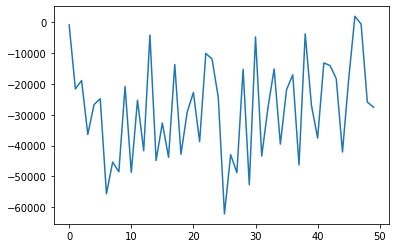

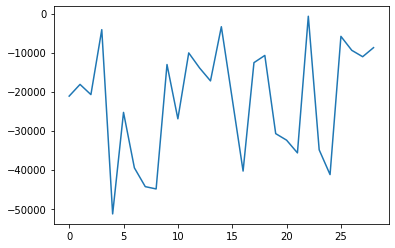

In [20]:
##### Here

gameStates = np.zeros((timeSteps, boardSize[0],boardSize[1] ))
#

agent = Agent(gamma=0.99, epsilon=1.0, lr=5e-4, n_actions=4, input_dims=[boardSize[0]*boardSize[1]], 
              mem_size=100000, batch_size=64, eps_min=0.01, eps_dec=1e-4, replace=100)
load_checkpoint = False

if load_checkpoint:
        agent.load_models()
        
scores, eps_hist = [], []
n_games = 50

score_saver = []
avg_score_saver = []
ddqn_scores = []
eps_history = []
savedGames = []
MAX_ITER = 60
prec = 20
reached = 0
reached_last_100 = 0
for i in tqdm(range(n_games)):
    score = 0
    done = False
    aimPos = np.array([np.random.randint(1,8)+2,np.random.randint(7,8)+2])
    playerpos = np.array([np.random.randint(1,8),np.random.randint(2,4)])            
    env = game(playerpos,aimPos)
    observation = env.reset()
    
    #if(i>n_games - 30):
    game_sav = []
    iteration = 0
    while not done:
        iteration +=1
        
        #save.append(observation)
        action = agent.choose_action(observation)
        observation_, reward, done = env.step(action)
        if reward == 10000:
            reached += 1
            if i > (n_games -100):
                reached_last_100 += 1
        score += reward
        agent.store_transition(observation, action,
                                    reward, observation_, int(done))
        
        agent.learn()
        observation = observation_
        #if(i>n_games - 10):
        game_sav.append(observation_)
        eps_history.append(agent.epsilon)

        ddqn_scores.append(score)
        if(i > 20):
            avg_score = np.mean(ddqn_scores[-10])
        
        if iteration == MAX_ITER:
            done = True

        if i % 10 == 0 and i > 0:
            agent.save_models()
    score_saver.append(score)
    if(i > 20):
        avg_score_saver.append(avg_score)
    #if(i>n_games - 10):
    savedGames.append(game_sav)
    if i % int(n_games/prec) == int(n_games/prec)-1:
            print('episode: ', i,'score: %.2f' % score,
                  ' average score %.2f' % avg_score,
                  'Epsilon %.3f' % agent.epsilon) 
    #if i == n_games-20:
    #    break     
print("")
print(str(n_games) + " Spieldurchläufe: "  +str(reached) + " mal Ziel erreicht, Quote = " + str(reached/n_games))
print("Quote der letzten 100 Durchläufe " + str(reached_last_100/100) )
plt.plot(score_saver)
plt.show()
plt.plot(avg_score_saver)
plt.show()

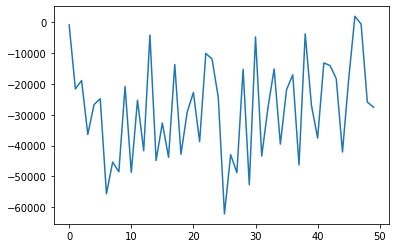

In [21]:
plt.plot(score_saver[-100:])

0.0 0.0


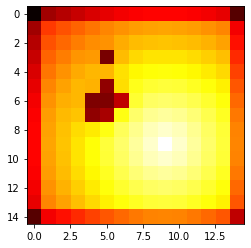

In [22]:
plt.imshow(showReward(savedGames[-1][0]) , cmap='hot', interpolation='nearest')

In [23]:
len(savedGames[-2])

33

MIN:1.0 0.0


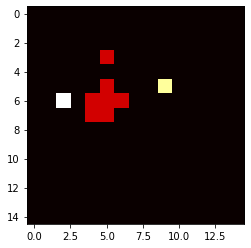

MIN:1.0 0.0


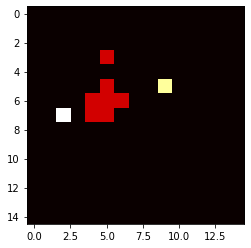

MIN:1.0 0.0


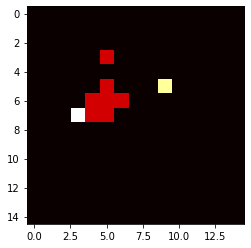

MIN:1.0 0.0


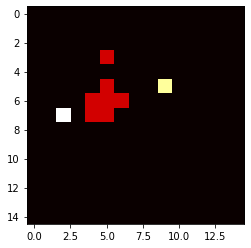

MIN:1.0 0.0


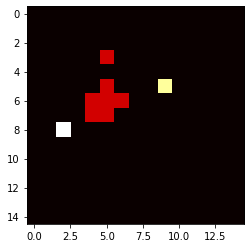

MIN:1.0 0.0


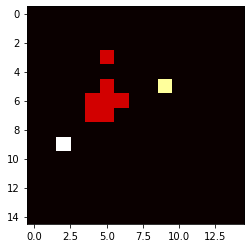

MIN:1.0 0.0


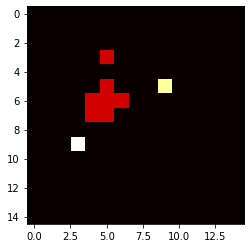

MIN:1.0 0.0


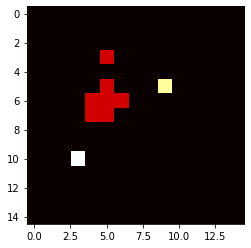

MIN:1.0 0.0


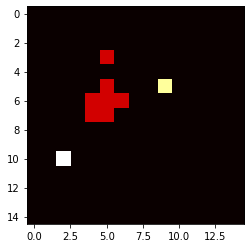

MIN:1.0 0.0


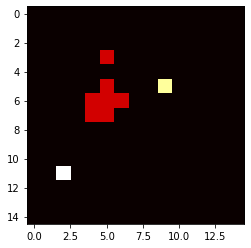

MIN:1.0 0.0


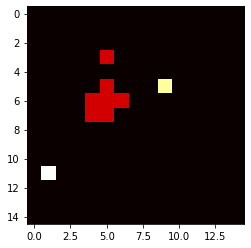

MIN:0.9 0.0


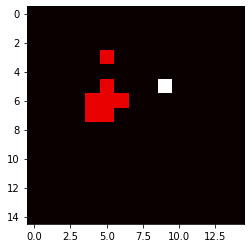

MIN:1.0 0.0


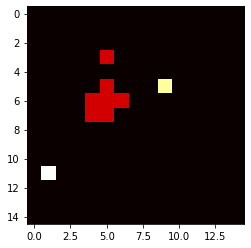

MIN:1.0 0.0


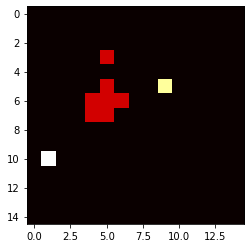

MIN:0.9 0.0


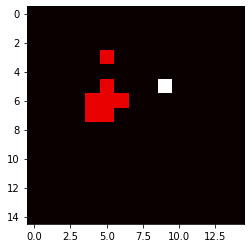

MIN:0.9 0.0


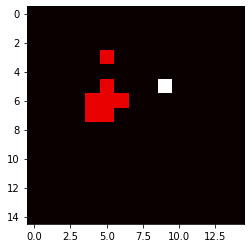

MIN:0.9 0.0


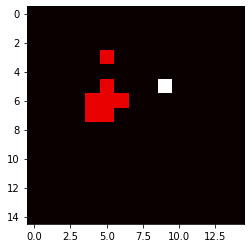

MIN:0.9 0.0


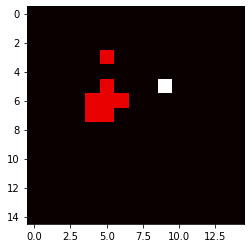

MIN:0.9 0.0


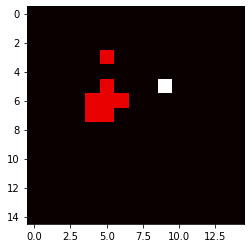

In [24]:
showhist_map(savedGames[-np.random.randint(1,50)])

MIN:1.0 0.0


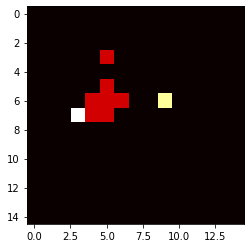

MIN:1.0 0.0


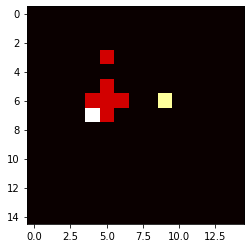

MIN:1.0 0.0


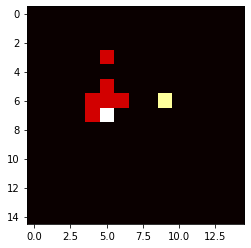

MIN:1.0 0.0


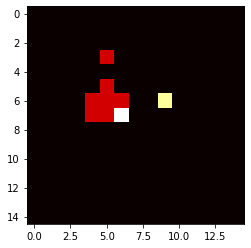

MIN:1.0 0.0


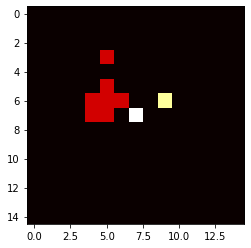

MIN:1.0 0.0


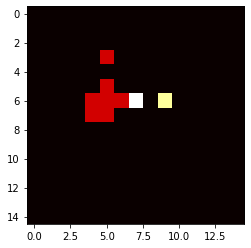

MIN:1.0 0.0


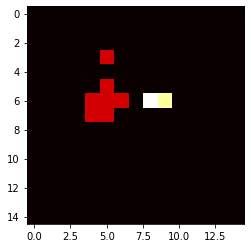

MIN:0.9 0.0


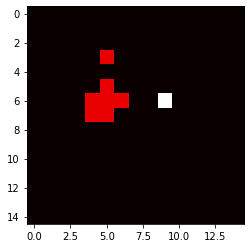

In [15]:
showhist_map(savedGames[-np.random.randint(1,50)])